In [1]:
import pandas as pd
import gzip
import json

In [2]:
def load_data(file_name, head = None):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [3]:
df_meta = pd.DataFrame(load_data(r"data\meta_Pet_Supplies.json.gz"))

In [4]:
df_review = pd.DataFrame(load_data(r"data\Pet_Supplies.json.gz"))

In [5]:
df_meta.category.explode().value_counts()[:10]

Pet Supplies                    189493
Dogs                            118176
Collars, Harnesses & Leashes     31083
Cats                             28383
Fish & Aquatic Pets              19061
Apparel & Accessories            17977
Toys                             17694
Collars                          15321
Treats                           15091
Food                             14196
Name: category, dtype: int64

In [6]:
df_meta.loc[lambda x: x.asin == "B000W5QSYA"]

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
30741,"[Pet Supplies, Dogs, Food, Dry]",,"[, Modern science proves that your dog shares ...",,Taste Of The Wild Grain Free High Protein Dry ...,"[B0043RWAVI, B000W5U5H6, B0097ETPRY, B0018CE6Z...",,Taste of the Wild,[A Taste Of The Wild With Roasted Quail; Real ...,"10,535 in Pet Supplies (","[B000W5U5H6, B0018CE6ZE, B0043RWAVI, B0097ETPR...",Pet Supplies,"class=""a-bordered a-horizontal-stripes a-spa...",,,B000W5QSYA,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{' Product Dimensions: ': '4 x 14 x 1...


In [7]:
df_meta.loc[lambda x: x.brand == "Taste of the Wild"].asin.nunique()

26

In [8]:
df_meta.loc[lambda x: x.brand == "Taste of the Wild"].explode("category").category.value_counts()

Pet Supplies              25
Food                      23
Dogs                      15
Dry                       13
Wet                       10
Canned                    10
Cats                       8
Pet Content - Main         2
Pet Content - Dog Main     2
Dog Food                   2
Name: category, dtype: int64

In [45]:
(
    df_meta
    .explode("category")
    .loc[
    lambda x: 
        (x.brand == "Taste of the Wild") &
        (x.category.isin(["Food"]))
    ]).title.unique()

array(['Taste Of The Wild Grain Free High Protein Dry Dog Food Wetlands - Roasted Duck',
       'Taste of the Wild Grain Free High Protein Real Meat Recipe Premium Dry Cat Food',
       'Taste of the Wild Grain Free Real Meat Recipe Premium Wet Canned Stew Dog Food',
       'Taste Of The Wild Fowl Dog Food, 13.2-Ounce',
       'Taste of the Wild Rocky Mountain Cat Food (5 lb)',
       'Taste of the Wild Grain Free Real Meat Recipe Premium Wet Canned Stew Cat Food',
       'Taste of the Wild Sierra Mountain Dog Food 15lb',
       'Taste of the Wild Sierra - 5 lbs',
       'Taste of the Wild Canyon River Can Cat, 24/3 Oz',
       'Taste Of The Wild High Prairie Can Dog Food,13.2 Oz',
       'Taste of the Wild Rocky Mountain Feline Formula, 5 Pounds',
       'Taste of the Wild Dry Dog Food, Hi Prairie Canine Formula with Roasted Bison &amp; Venison, 30-Pound Bag (jumbo pack 60 pound)',
       'Taste Of The Wild Wetlands Dry Dog Food',
       'Taste of the Wild Dry Dog Food, Hi Prairie Can

In [46]:
totw_dog_food_asin = (
    df_meta
    .explode("category")
    .loc[
    lambda x: 
        (x.brand == "Taste of the Wild") &
        (x.category.isin(["Food"]))
    ]
).asin.unique()

In [47]:
dog_food_asin = (
    df_meta
    .explode("category")
    .loc[
    lambda x: 
        (x.category.isin(["Food"]))
    ]
).asin.unique()

In [48]:
df_review.loc[lambda x: x.asin.isin(dog_food_asin)].shape

(546179, 12)

In [49]:
df_review.loc[lambda x: x.asin.isin(totw_dog_food_asin)].shape

(36800, 12)

<Axes: ylabel='Frequency'>

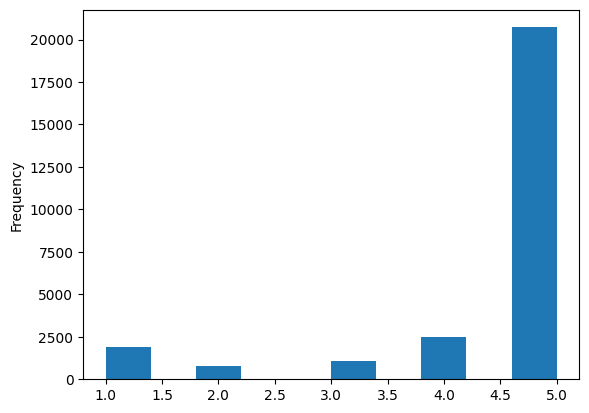

In [14]:
df_review.loc[lambda x: x.asin == "B000W5QSYA"].overall.plot(kind="hist")

----------------------------------------------------------------------------------------------------------------------

## Prepare Data

In [15]:
df_totw = df_review.loc[lambda x: (x.asin.isin(totw_dog_food_asin)) & (~x.reviewText.isna())]

In [52]:
df_totw.overall.value_counts()

5.0    27811
4.0     3487
1.0     2719
3.0     1608
2.0     1161
Name: overall, dtype: int64

In [16]:
from joblib import Parallel, delayed

import nltk
from nltk.corpus import stopwords
import string

# Load the stopwords
STOP_WORDS = set(stopwords.words('english'))

In [17]:
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = ''.join(word for word in text if not word.isdigit())
    # Tokenize text
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words
    tokens = [token for token in tokens if token not in STOP_WORDS]
    # Rejoin tokens into a string
    text = ' '.join(tokens)
    return text

def pre_process_column(df:pd.DataFrame) -> pd.DataFrame:
    assert "reviewText" in df.columns
    df = df.assign(
        preprocessed_text = Parallel(n_jobs=8)(delayed(preprocess_text)(text) for text in df.reviewText)
        )
    return df

In [18]:
df_totw = pre_process_column(df_totw)

In [19]:
df_totw.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,preprocessed_text
1404950,5.0,22,False,"01 12, 2009",A3GBY9HEHC767B,B000W5QSYA,Lori A. Witkop,After trying MANY other foods I finally found ...,"DOG TESTED, MOTHER APPROVED!!!!!!!",1231718400,NaN,NaN,after trying many other foods i finally found ...
1404951,5.0,37,False,"10 7, 2008",A2VMFC3QRZFPYC,B000W5QSYA,Mrs. O,I couldn't understand why one of my dogs had a...,"Finally, a high protein dog food my dogs love.",1223337600,NaN,NaN,i couldnt understand why one of my dogs had al...
1404952,5.0,3,False,"07 30, 2008",A3STUI3SPCT1KC,B000W5QSYA,R. Ferrell,I have had a terrible time finding a dry dog f...,My boston terriers love this!,1217376000,"{'Size:': ' 30lb', 'Flavor Name:': ' Wetlands ...",NaN,i have had a terrible time finding a dry dog f...
1404953,5.0,18,False,"06 25, 2008",ANSA83I0WOUR2,B000W5QSYA,Claudia,I've been very happy with Taste of the Wild ev...,Great food,1214352000,"{'Size:': ' 30lb', 'Flavor Name:': ' Wetlands ...",NaN,ive been very happy with taste of the wild eve...
1405003,5.0,NaN,True,"05 21, 2018",A3C6DMUE0IEL4H,B000W5QSYA,Reese Brown,I went from a food with grains and crap to thi...,I went from a food with grains and crap to this,1526860800,"{'Size:': ' 30lb', 'Flavor Name:': ' High Prai...",NaN,i went from a food with grains and crap to thi...


## Modelling

In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix

from pprint import pprint
from time import time
import logging

In [21]:
sns.set_theme("notebook")

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_totw, df_totw.overall, test_size=0.33, random_state=42)

In [23]:
vectorizer = TfidfVectorizer(smooth_idf=False,
                             ngram_range = (1,4),
                             stop_words="english"
                             )

In [24]:
X_train_vec = vectorizer.fit_transform(X_train.preprocessed_text)
X_test_vec = vectorizer.transform(X_test.preprocessed_text)

In [25]:
pac = PassiveAggressiveClassifier(C=1.0)
pac.fit(X_train_vec,  y_train)
y_pred = pac.predict(X_test_vec)

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [27]:
cm = confusion_matrix(y_test, y_pred, labels=pac.classes_)

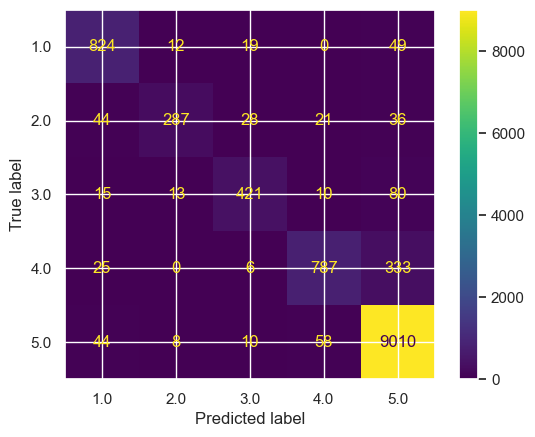

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pac.classes_)
disp.plot()
plt.show()

In [36]:
feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(sorted(zip(pac.coef_[0], feature_names),reverse=True)).to_csv(r"one_star.csv")

In [37]:
feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(sorted(zip(pac.coef_[1], feature_names),reverse=True)).to_csv(r"two_star.csv")

In [38]:
feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(sorted(zip(pac.coef_[2], feature_names),reverse=True)).to_csv(r"three_star.csv")

In [39]:
feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(sorted(zip(pac.coef_[3], feature_names),reverse=True)).to_csv(r"four_star.csv")

In [45]:
feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(sorted(zip(pac.coef_[4], feature_names),reverse=True)).to_csv(r"five_star.csv")

<Axes: ylabel='Frequency'>

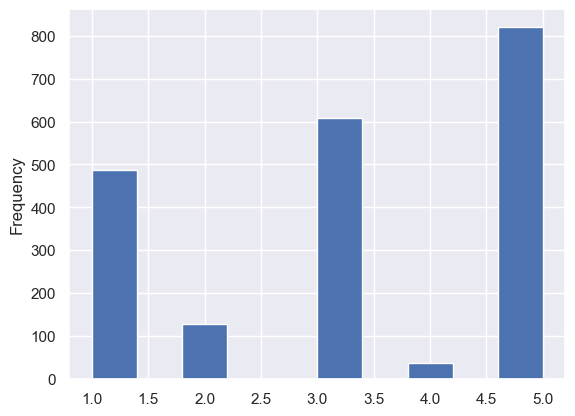

In [ ]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("touch"))].overall.plot(kind="hist")

<Axes: ylabel='Frequency'>

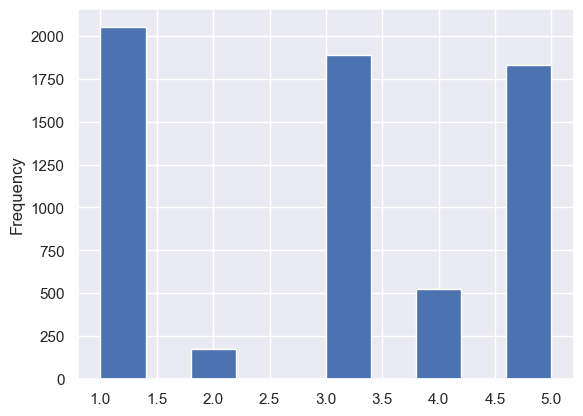

In [ ]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("smell"))].overall.plot(kind="hist")

<Axes: ylabel='Frequency'>

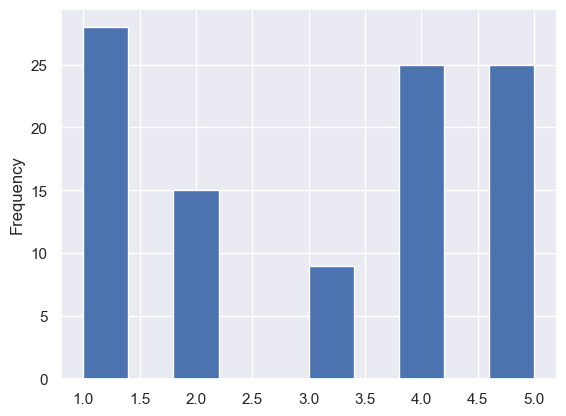

In [ ]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("overpriced"))].overall.plot(kind="hist")

<Axes: ylabel='Frequency'>

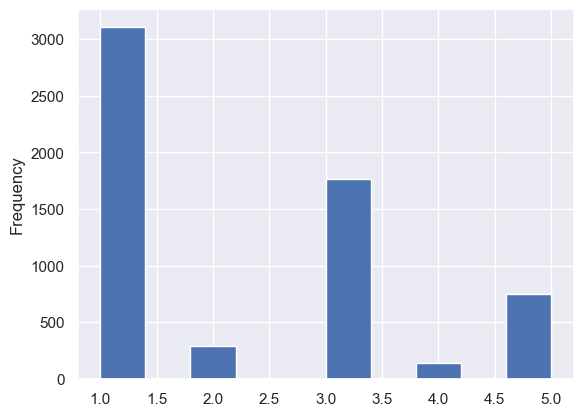

In [ ]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("sick"))].overall.plot(kind="hist")

<Axes: ylabel='Frequency'>

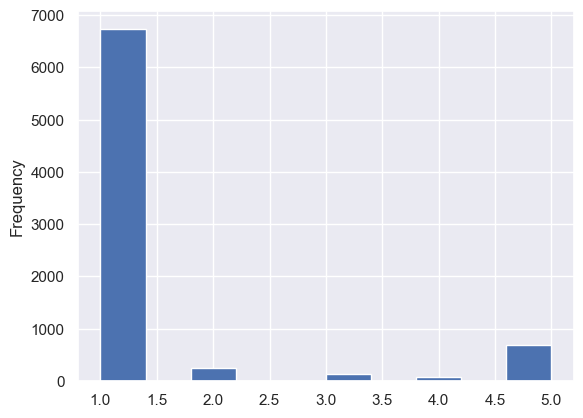

In [ ]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("diarrhea"))].overall.plot(kind="hist")

<Axes: ylabel='Frequency'>

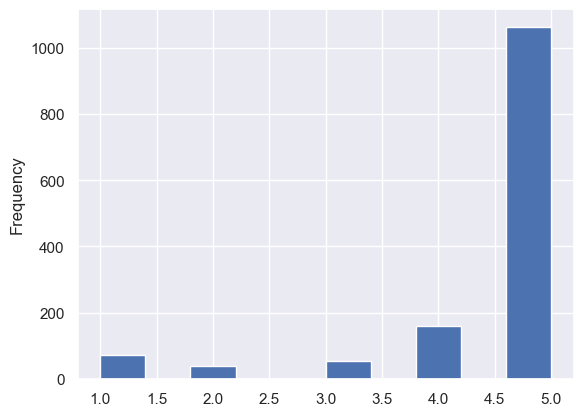

In [53]:
df_totw.loc[lambda x: ((x.preprocessed_text.str.contains("expensive")))].overall.plot(kind="hist")

In [54]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("expensive"))].overall.value_counts()

5.0    1064
4.0     160
1.0      71
3.0      55
2.0      40
Name: overall, dtype: int64

In [64]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("expensive but"))].reset_index().reviewText[2]

'very high quality if you would like to feed your dog a high protein diet. lots of interesting different types of flavors. downside in my opinion is that the kibbles can be hard. also need to vary the diet and not feed the same thing all the time. this brand gets expensive, but is much better than the corn and wheat based products. guess nothing is perfect out there, but this is a very good start in the quest for a high quality dog food.'

In [55]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("gas"))].overall.value_counts()

5.0    664
4.0    135
1.0    118
2.0     61
3.0     57
Name: overall, dtype: int64

In [73]:
df_totw.loc[lambda x: (x.preprocessed_text.str.contains("gas"))]#.reviewText[5482160]

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,preprocessed_text
1405129,4.0,NaN,True,"04 28, 2018",A1JOMCJX2VFFX0,B000W5QSYA,E. Lee,I like the ingredients in this brand. before I...,Great ingredients but makes my dog gassy!,1524873600,"{'Size:': ' 30lb', 'Flavor Name:': ' Wetlands ...",NaN,i like the ingredients in this brand before i ...
1405130,2.0,6,True,"04 28, 2018",A2Z7BOJFUIGTHS,B000W5QSYA,Stephen P Rousset,"We've ordered this dog food 6 times from AMZN,...","When it's good, it's good. When it's bad, it'...",1524873600,"{'Size:': ' 30lb', 'Flavor Name:': ' Wetlands ...",NaN,weve ordered this dog food times from amzn wit...
1405132,5.0,NaN,True,"04 27, 2018",A2EY2H2G7WP1NX,B000W5QSYA,Breeze,A food our dogs will actually eat without maki...,Five Stars,1524787200,"{'Size:': ' 30lb', 'Flavor Name:': ' High Prai...",NaN,a food our dogs will actually eat without maki...
1405161,5.0,NaN,True,"04 23, 2018",A1M5HKSGF2AVWE,B000W5QSYA,Alena M. Clark,Our dogs love this flavor but we love this bra...,Our dogs love this flavor but we love this brand.,1524441600,"{'Size:': ' 5lb', 'Flavor Name:': ' Southwest ...",NaN,our dogs love this flavor but we love this bra...
1405267,1.0,3,True,"04 12, 2018",ANQ78JHLLYR2D,B000W5QSYA,Angelina,0 stars! FAKE DO NOT BUY! Its been almost a w...,Be aware do not buy from amazon!,1523491200,"{'Size:': ' 5lb', 'Flavor Name:': ' High Prair...",NaN,stars fake do not buy its been almost a week a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5482100,5.0,NaN,True,"11 27, 2011",A1QSXS0RC1H1DH,B01E7NPFXC,Angie,I have an English Mastiff and an English Bulld...,Great all around nutrition,1322352000,NaN,NaN,i have an english mastiff and an english bulld...
5482148,5.0,NaN,True,"01 31, 2011",A4DT2XL6NB3QY,B01E7NPFXC,Jackie Menzies,"My 2 beagles love this food, I was a little wo...",Dogs Love this Food and feel Full,1296432000,NaN,NaN,my beagles love this food i was a little worri...
5482160,5.0,9,False,"09 2, 2010",A21I6Z8FXXD4AO,B01E7NPFXC,Jay,After trying a few different brands of grain-f...,Great Product,1283385600,NaN,NaN,after trying a few different brands of grainfr...
5482162,5.0,6,False,"06 9, 2010",A2Q2A6JKY95RTP,B01E7NPFXC,Raul G.,I have a French Bulldog that has developed foo...,Frenchie Approved,1276041600,NaN,NaN,i have a french bulldog that has developed foo...


In [39]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

In [41]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

In [42]:
vectorized_data = vectorizer.fit_transform(df_totw.loc[lambda x: x.overall.isin([1,2,3])].preprocessed_text)

In [43]:
n_topics = 5
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42)
lda_output = lda_model.fit_transform(vectorized_data)

In [44]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, vectorized_data, vectorizer, mds='tsne')
pyLDAvis.save_html(vis, 'totw_topic_dog_food_reviews_vis_neg.html')

c:\Users\dahiy\miniconda3\envs\news\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
